In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 51.7 MB/s eta 0:00:00


In [4]:
!pip install -U keras-cv-attention-models


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.3/796.3 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00


In [5]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch


In [3]:
# Define paths for data and model saving
data_dir = '/content/drive/MyDrive/Orange_Dataset/train'
test_dir = '/content/drive/MyDrive/Orange_Dataset/test'
convnext_path = '/content/drive/MyDrive/model_convnext.h5'

In [4]:
# Set up data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    brightness_range=[0.7, 1.3],
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Data generator for testing (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Training and validation data generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)

# Testing data generator (no augmentation applied here)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)


Found 6659 images belonging to 3 classes.
Found 1662 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [5]:
# Create a ConvNeXt base model using timm
# Use torch to load pretrained weights
convnext_model = timm.create_model('convnext_tiny', pretrained=True)
convnext_model.eval()

# Freeze all the layers
for param in convnext_model.parameters():
    param.requires_grad = False

# Define a wrapper that makes it compatible with Keras (TensorFlow) via tf.keras.Model
# We'll extract features from PyTorch, save them as numpy arrays, and feed them to Keras
# So here we define just the classification head
def build_convnext_head(num_classes=3):
    input_tensor = Input(shape=(768,))  # 768 is the output dimension of convnext_tiny
    x = Dense(256, activation='relu')(input_tensor)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=input_tensor, outputs=output_tensor)

convnext_head = build_convnext_head(num_classes=3)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [6]:
import torch.nn as nn

# Remove the classification head of ConvNeXt to get features
class ConvNeXtFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(ConvNeXtFeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-2])  # Remove the final classifier

    def forward(self, x):
        x = self.features(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Global avg pool
        x = x.view(x.size(0), -1)
        return x

feature_extractor = ConvNeXtFeatureExtractor(convnext_model).eval()


In [7]:
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

# Define preprocessing for images as expected by ConvNeXt
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Extract features and labels from a generator
def extract_features(generator, feature_extractor):
    features = []
    labels = []

    for i in tqdm(range(len(generator))):
        x_batch, y_batch = generator[i]
        for img in x_batch:
            img_pil = Image.fromarray((img * 255).astype(np.uint8))  # Convert from float32 to uint8 PIL image
            img_torch = preprocess(img_pil).unsqueeze(0)
            with torch.no_grad():
                feat = feature_extractor(img_torch).squeeze().numpy()
            features.append(feat)
        labels.append(y_batch)

    features = np.array(features)
    labels = np.vstack(labels)
    return features, labels


In [9]:
train_features, train_labels = extract_features(train_generator, feature_extractor)
val_features, val_labels = extract_features(val_generator, feature_extractor)
test_features, test_labels = extract_features(test_generator, feature_extractor)


100%|██████████| 3/3 [01:25<00:00, 28.56s/it]


In [10]:
def build_classifier(input_dim, num_classes):
    inputs = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# Input dimension depends on ConvNeXt output (usually 768 for tiny model)
classifier = build_classifier(input_dim=train_features.shape[1], num_classes=3)
classifier.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Define the classifier
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(train_features.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes: Canker, Melanose, Healthy
])

# Compile the model
classifier.compile(optimizer=Adam(learning_rate=1e-4),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Train the classifier
history = classifier.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7556 - loss: 0.6263 - val_accuracy: 0.8833 - val_loss: 0.4182 - learning_rate: 1.0000e-04
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9313 - loss: 0.1925 - val_accuracy: 0.9061 - val_loss: 0.2831 - learning_rate: 1.0000e-04
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9461 - loss: 0.1468 - val_accuracy: 0.9134 - val_loss: 0.2380 - learning_rate: 1.0000e-04
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9550 - loss: 0.1212 - val_accuracy: 0.9188 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9601 - loss: 0.1035 - val_accuracy: 0.9230 - val_loss: 0.2146 - learning_rate: 1.0000e-04
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9673 - loss: 0.0863 - val_accuracy: 0.9218 - val_loss: 0.2124 - learning_rate: 1.0000e-04
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accura

In [12]:
# Save the trained classifier model
classifier.save(convnext_path)
print("✅ Classifier model saved as 'convnext_classifier_head.h5'")


✅ Classifier model saved as 'convnext_classifier_head.h5'


In [13]:
# Evaluate the classifier on test set
test_loss, test_accuracy = classifier.evaluate(test_features, test_labels)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9330 - loss: 0.1566 

✅ Test Accuracy: 0.9700


<ipython-input-15-13bef1e70b0f>:22: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


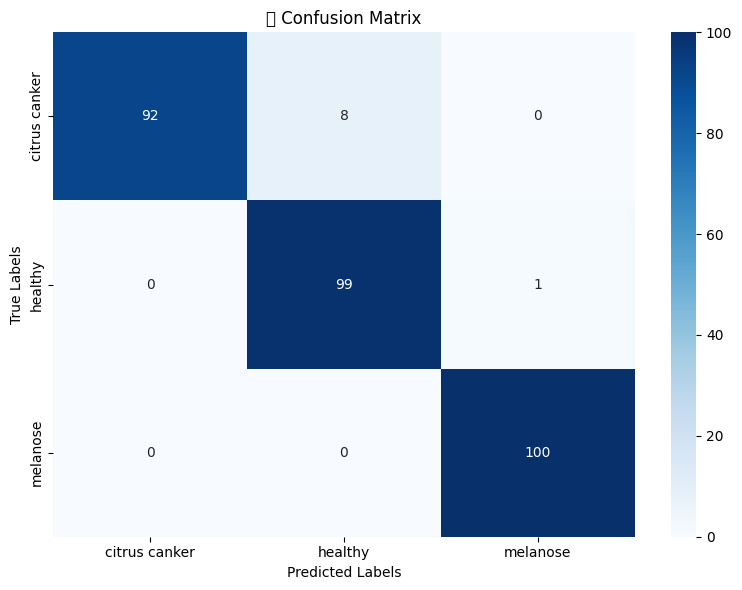

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true and predicted class indices
true_classes = np.argmax(test_labels, axis=1)
pred_classes = np.argmax(pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(" Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Step 1: Convert one-hot labels to class indices
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(pred_probs, axis=1)

# Step 2: Class names from generator
class_names = list(test_generator.class_indices.keys())

# Step 3: Classification report (precision, recall, F1)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Print detailed classification report
print("Classification Report:")
print(report_df)

# Optional: Save report to CSV
report_df.to_csv("classification_report_convnext.csv")

# Step 4: Print overall scores
overall_accuracy = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')

print(f"\n Overall Accuracy: {overall_accuracy:.4f}")
print(f" Macro F1-score: {macro_f1:.4f}")
print(f" Weighted F1-score: {weighted_f1:.4f}")
print(f" Macro Precision: {macro_precision:.4f}")
print(f" Macro Recall: {macro_recall:.4f}")


📝 Classification Report:
               precision  recall  f1-score  support
citrus canker   1.000000    0.92  0.958333   100.00
healthy         0.925234    0.99  0.956522   100.00
melanose        0.990099    1.00  0.995025   100.00
accuracy        0.970000    0.97  0.970000     0.97
macro avg       0.971778    0.97  0.969960   300.00
weighted avg    0.971778    0.97  0.969960   300.00

✅ Overall Accuracy: 0.9700
📊 Macro F1-score: 0.9700
📊 Weighted F1-score: 0.9700
📊 Macro Precision: 0.9718
📊 Macro Recall: 0.9700
